In [473]:
%matplotlib inline

In [720]:
from model.cae import CAE
from model import metrics

from utils import plot_paired_imgs
from utils import plot_sample_imgs

import urllib
import gzip
import pickle
import os

import numpy as np
import pandas as pd

In [481]:
from datetime import datetime

In [570]:
from keras.callbacks import TensorBoard

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [476]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimage
import seaborn as sns

In [477]:
def reshape_mnist(vectors):
    images = np.reshape(vectors, (-1,28,28,1))
    return images

__Read data__

In [271]:
mnistfile = 'mnist.pkl.gz'

if not os.path.isfile(mnistfile):
    url = urllib.request.URLopener()
    url.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", mnistfile)
    
with gzip.open(mnistfile, 'rb') as f:
    training_set, validation_set, testing_set = pickle.load(f, encoding='latin1')

In [272]:
X_train,    y_train    = training_set
X_validate, y_validate = validation_set
X_test,     y_test     = testing_set

In [273]:
X_train    = reshape_mnist(X_train)
X_validate = reshape_mnist(X_validate)
X_test     = reshape_mnist(X_test)

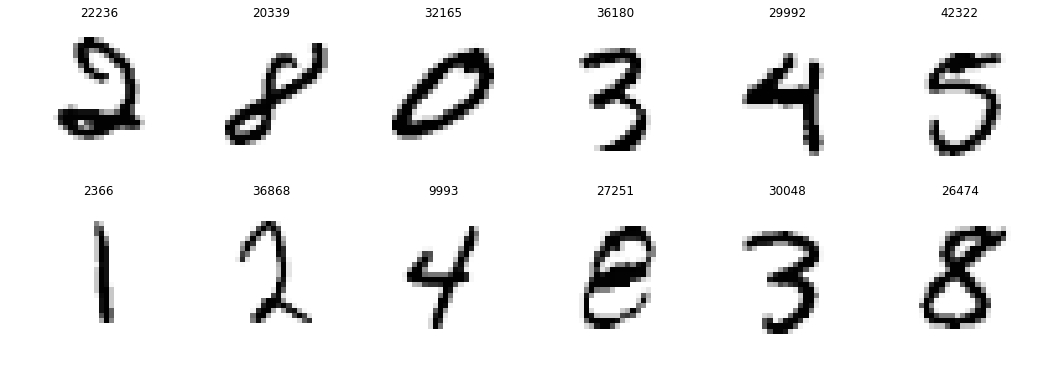

In [274]:
plot_many_img(X_train, 2, 6)

__Train model__

In [542]:
# initialize ConvAutoEncoder model
cae = CAE(input_shape=X_train[0].shape, output_dim=20, filters=[8,16])

In [543]:
tb = TensorBoard(log_dir='./logs/' + datetime.now().strftime('%Y%m%d_%H%M'), 
                 write_grads=True, write_images=True)

In [544]:
# fit to training, validation data
cae.fit(X_train, X_train, epochs=30, callbacks=[tb])

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 24s 534us/step - loss: 0.0401 - val_loss: 0.0244
Epoch 2/30
45000/45000 [==============================] - 25s 552us/step - loss: 0.0210 - val_loss: 0.0202
Epoch 3/30
45000/45000 [==============================] - 24s 533us/step - loss: 0.0182 - val_loss: 0.0177
Epoch 4/30
45000/45000 [==============================] - 25s 553us/step - loss: 0.0161 - val_loss: 0.0164
Epoch 5/30
45000/45000 [==============================] - 26s 587us/step - loss: 0.0151 - val_loss: 0.0157
Epoch 6/30
45000/45000 [==============================] - 25s 545us/step - loss: 0.0145 - val_loss: 0.0152
Epoch 7/30
45000/45000 [==============================] - 24s 538us/step - loss: 0.0140 - val_loss: 0.0146
Epoch 8/30
45000/45000 [==============================] - 25s 553us/step - loss: 0.0136 - val_loss: 0.0143
Epoch 9/30
45000/45000 [==============================] - 26s 585us/step - loss: 0.0133 - val_l

In [582]:
cae.save_weights()

In [586]:
cae2.load_weights()

__Run Predictions__

In [545]:
X_train_pred = ce.model.predict(X_train)
X_test_pred = cae.model.predict(X_test)

X_train_enc = cae.encoder.predict(X_train)
X_test_enc = cae.encoder.predict(X_test)

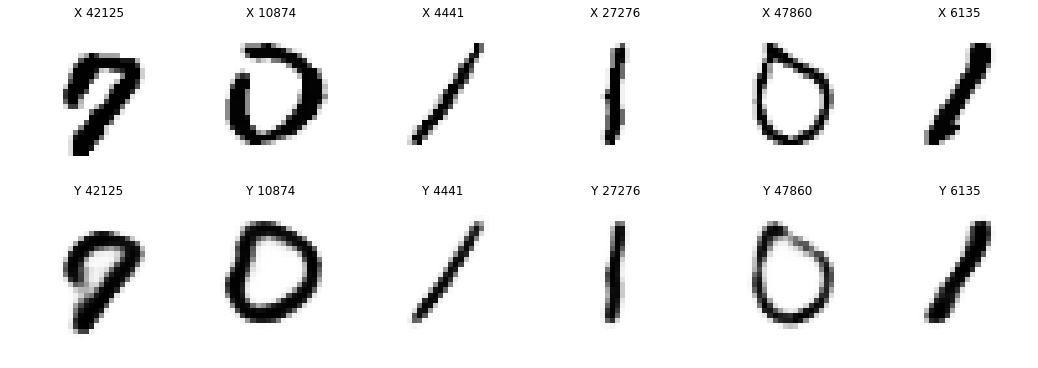

In [598]:
plot_paired_imgs(X_train, X_train_pred, N=6, orient='h')

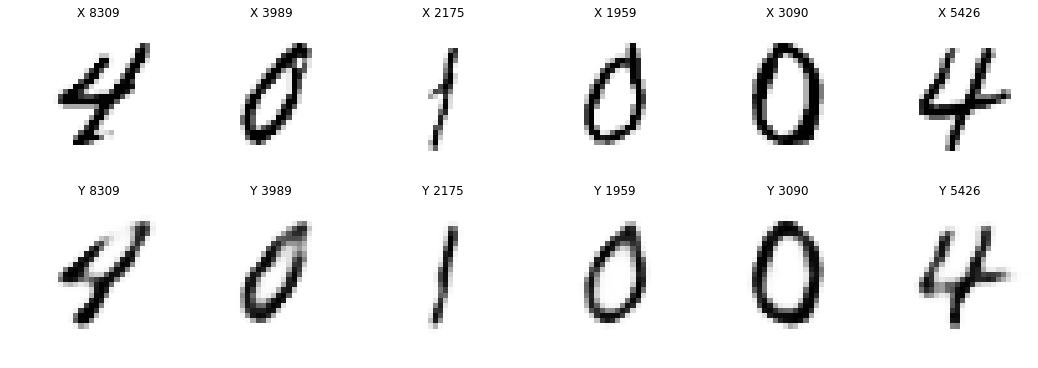

In [599]:
plot_paired_imgs(X_test, X_test_pred, N=6, orient='h')

__RandomForest__

In [552]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)

In [553]:
rf.fit(X_train_enc, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [554]:
y_train_pred = rf.predict(X_train_enc)
y_test_pred = rf.predict(X_test_enc)

In [555]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4932
           1       1.00      1.00      1.00      5678
           2       1.00      1.00      1.00      4968
           3       1.00      1.00      1.00      5101
           4       1.00      1.00      1.00      4859
           5       1.00      1.00      1.00      4506
           6       1.00      1.00      1.00      4951
           7       1.00      1.00      1.00      5175
           8       1.00      1.00      1.00      4842
           9       1.00      1.00      1.00      4988

   micro avg       1.00      1.00      1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



In [556]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.92      0.95      0.94      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.93      0.94       892
           6       0.97      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.90      0.92       974
           9       0.94      0.92      0.93      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



Text(83.94, 0.5, 'Prediction')

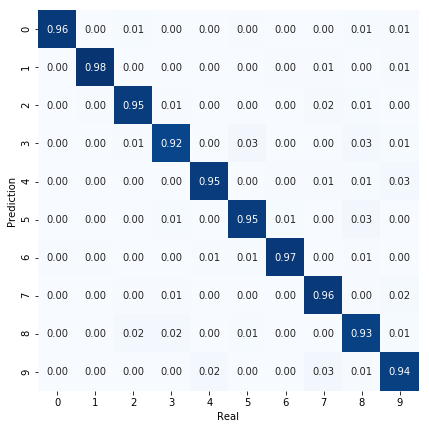

In [557]:
plt.figure(figsize=(8,7))

sns.heatmap(pd.crosstab(y_test_pred, y_test, normalize='index'), 
            cmap='Blues', annot=True, fmt='.2f', square=True, vmax=1, vmin=0, cbar=False)

plt.xlabel('Real')
plt.ylabel('Prediction')

**PCA**

In [558]:
pca = PCA(n_components=2)

In [559]:
X_train_enc_pca = pca.fit_transform(X_train_enc)

In [560]:
X_train_enc_pca[:,1]

array([-2.3 , -0.85,  4.97, ..., -0.03,  0.71,  1.49], dtype=float32)

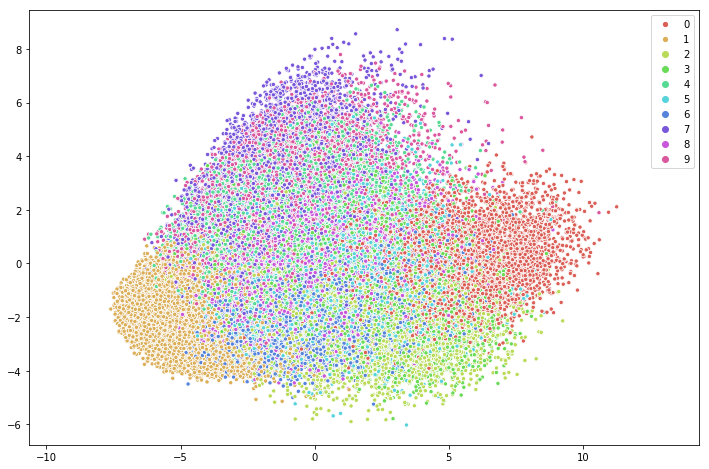

In [566]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_train_enc_pca[:,0], y=X_train_enc_pca[:,1], hue=y_train, size=1,
                palette=sns.color_palette("hls", 10))
plt.axis('equal')
pass

In [539]:
X_train_v = X_train.reshape(50000,28*28)

In [540]:
X_train_pca = pca.fit_transform(X_train_v)

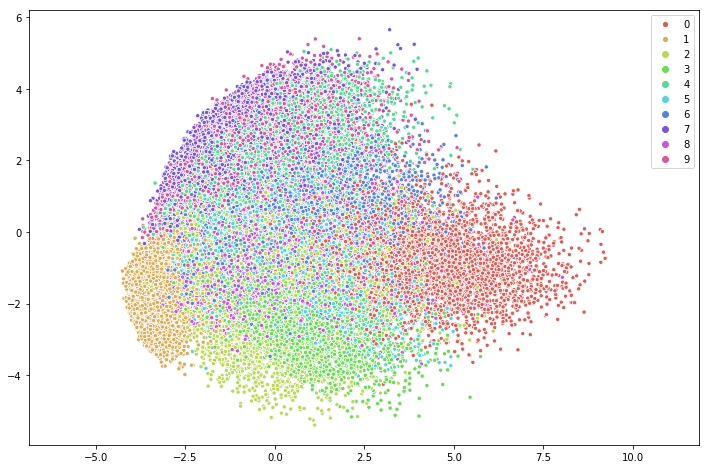

In [567]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train, size=1,
                palette=sns.color_palette("hls", 10))
plt.axis('equal')
pass

__tSNE__

In [569]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_train_enc_tsne = tsne.fit_transform(X_train_enc)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.051s...
[t-SNE] Computed neighbors for 50000 samples in 50.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

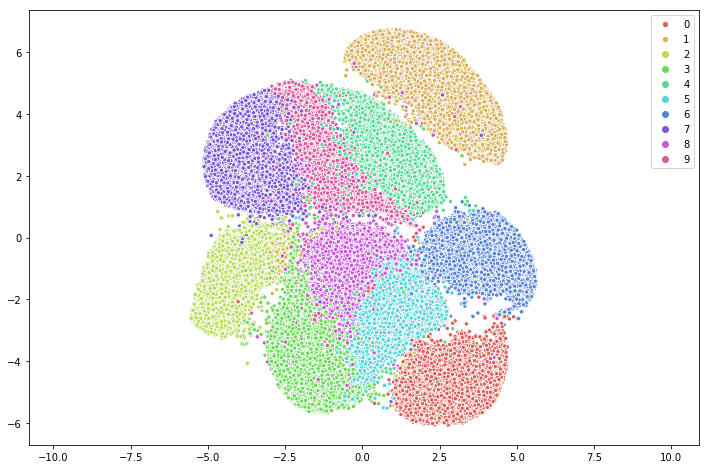

In [571]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_train_enc_tsne[:,0], y=X_train_enc_tsne[:,1], hue=y_train, size=1,
                palette=sns.color_palette("hls", 10))
plt.axis('equal')
pass

__Clustering: KMeans__

In [514]:
K = 20
kmeans = KMeans(n_clusters=K)

In [572]:
y_train_clust = kmeans.fit_predict(X_train_enc_tsne)

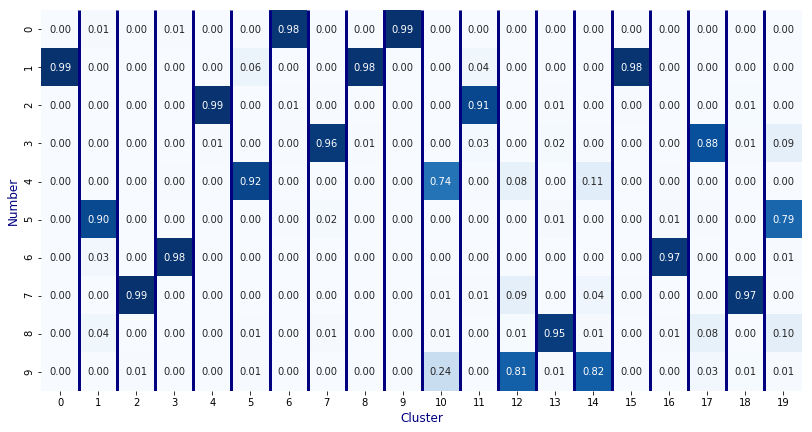

In [574]:
plt.figure(figsize=(14,7))

sns.heatmap(freq_table.transpose(), cmap='Blues', square=True, 
           annot=True, fmt='.2f', vmax=1, vmin=0, cbar=False)

plt.xlabel('Cluster', fontsize=12, color='navy')
plt.ylabel('Number', fontsize=12, color='navy')

plt.vlines(list(range(1, K)) ,0, 10, lw=3, color='navy')

In [731]:
ginis = metrics.cluster_gini(y_train_clust, y_train)

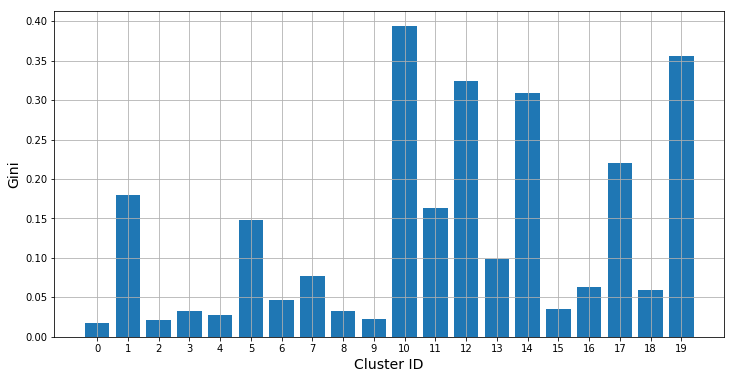

In [738]:
plt.figure(figsize=(12,6))

plt.bar(ginis.keys(), ginis.values())
plt.xticks(list(ginis.keys()))

plt.xlabel('Cluster ID', fontsize=14)
plt.ylabel('Gini', fontsize=14)

plt.grid()
pass

 Cluster 0


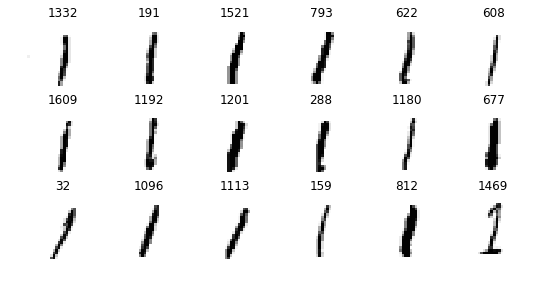

 Cluster 1


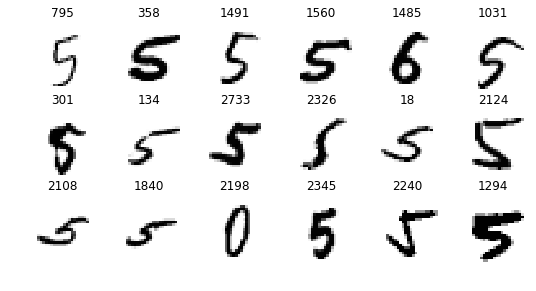

 Cluster 2


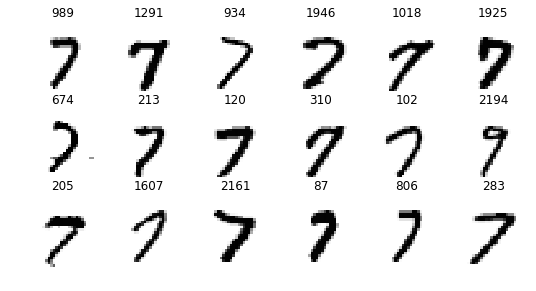

 Cluster 3


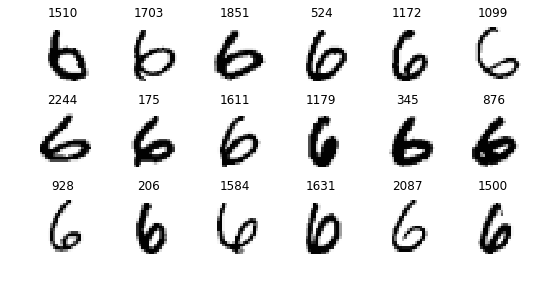

 Cluster 4


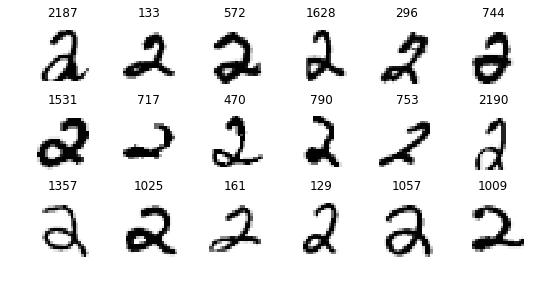

 Cluster 5


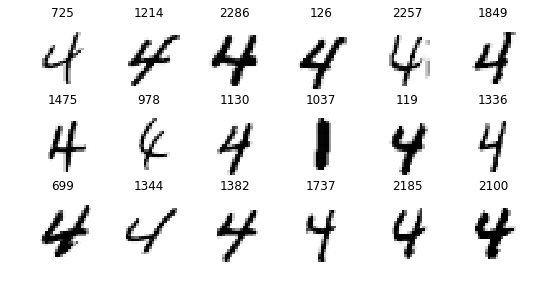

 Cluster 6


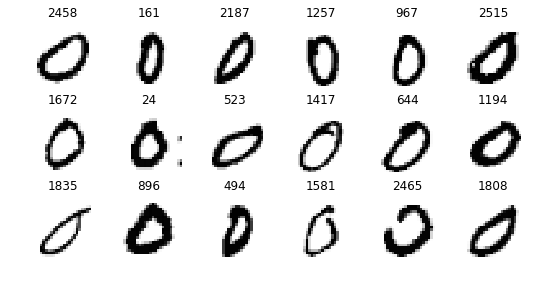

 Cluster 7


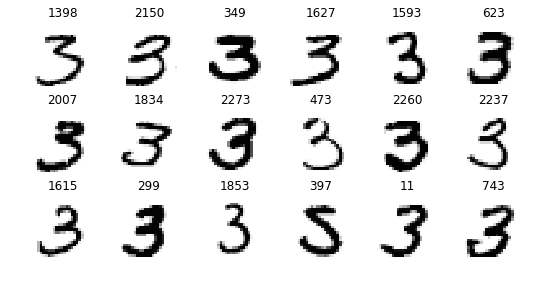

 Cluster 8


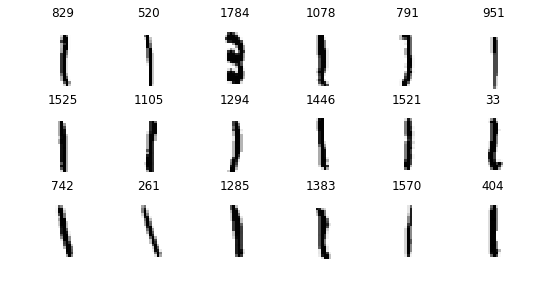

 Cluster 9


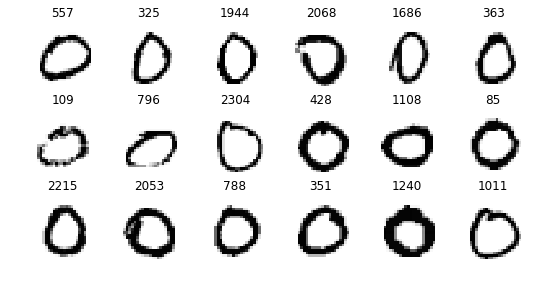

 Cluster 10


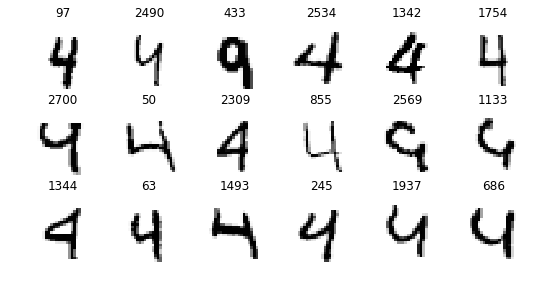

 Cluster 11


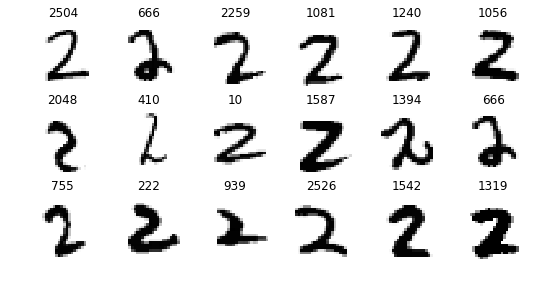

 Cluster 12


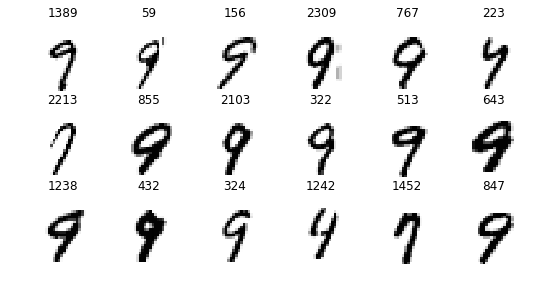

 Cluster 13


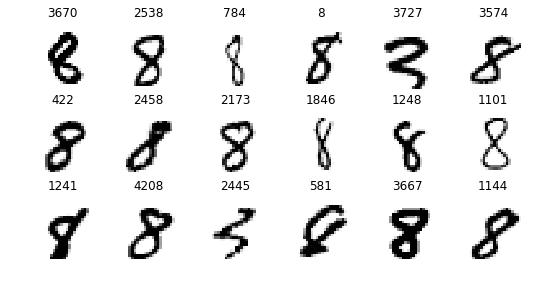

 Cluster 14


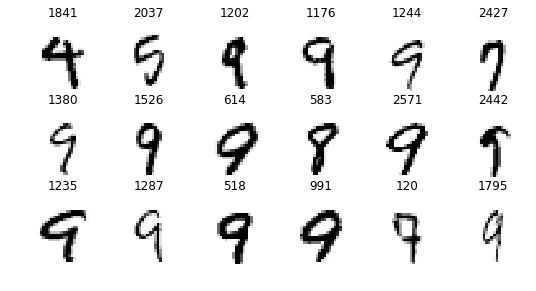

 Cluster 15


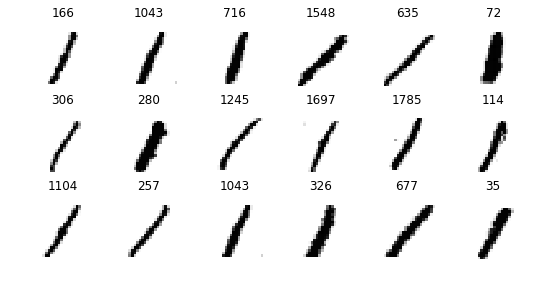

 Cluster 16


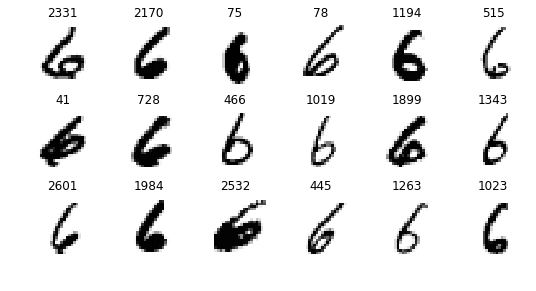

 Cluster 17


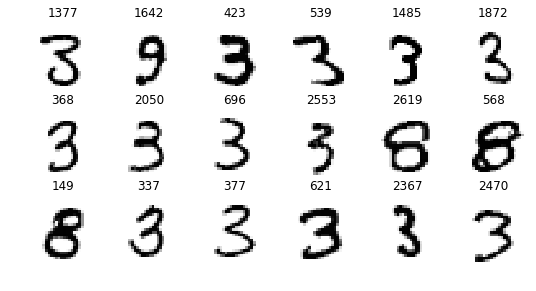

 Cluster 18


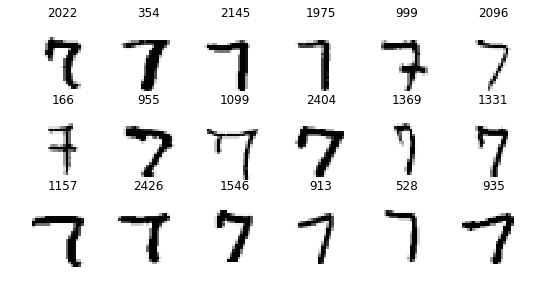

 Cluster 19


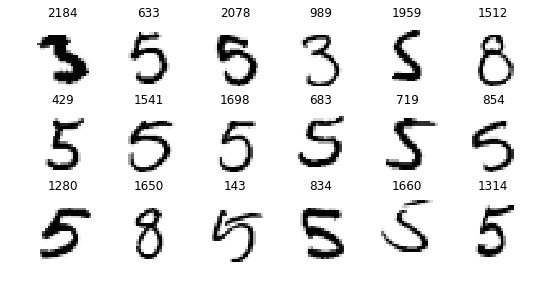

In [575]:
for cluster in range(K):
    print('\033[1m Cluster {}'.format(cluster))
    plot_sample_imgs(X_train[y_train_clust == cluster], n_rows=3, n_cols=6, size=1.5)
    plt.show()